[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab3-GenAI-LLM/notebooks/03-llm-grunnleggende.ipynb)

# Store Språkmodeller (LLM) - Grunnleggende konsepter

**ELMED219 / BMED365 - Lab 3**

---

## Læringsmål

Etter denne notebooken skal du kunne:
- Forstå hvordan LLM genererer tekst token for token
- Forklare hva tokens og embeddings er
- Beskrive hvordan temperature påvirker tekstgenerering
- Forstå begrensninger med kontekstvindu

## Innhold

1. [Miljøoppsett](#1-miljøoppsett)
2. [Tokenisering](#2-tokenisering)
3. [Temperature og sampling](#3-temperature-og-sampling)
4. [Kontekstvindu](#4-kontekstvindu)
5. [Praktiske implikasjoner](#5-praktiske-implikasjoner)

---

## 1. Miljøoppsett

In [1]:
import sys
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Kjører i Google Colab")
    !pip install tiktoken --quiet
else:
    print("Kjører i lokalt miljø")

# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Tokenizer
try:
    import tiktoken
    TIKTOKEN_AVAILABLE = True
    print("tiktoken tilgjengelig")
except ImportError:
    TIKTOKEN_AVAILABLE = False
    print("tiktoken ikke tilgjengelig - noen eksempler vil bruke simulerte data")

print("Miljø er konfigurert!")

Kjører i lokalt miljø
tiktoken tilgjengelig
Miljø er konfigurert!


---

## 2. Tokenisering

### Hva er tokens?

LLM-er leser ikke tekst tegn for tegn eller ord for ord. De bruker **tokens** - som er et kompromiss mellom de to.

Et token kan være:
- Et helt ord: "pasient"
- En del av et ord: "pas" + "ient"
- Tegnsetting: ".", ","
- Spesialtegn: mellomrom, linjeskift

### Hvorfor tokenisering?

1. **Effektivitet**: Færre enheter å prosessere enn individuelle tegn
2. **Fleksibilitet**: Kan håndtere ukjente ord ved å dele dem opp
3. **Språknøytralitet**: Samme system fungerer for ulike språk

In [2]:
if TIKTOKEN_AVAILABLE:
    # Bruk OpenAI's tokenizer (samme som GPT-3.5/GPT-4)
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    
    # Medisinsk eksempel
    tekst = "Pasienten har diabetes mellitus type 2 og hypertensjon."
    tokens = encoding.encode(tekst)
    token_strings = [encoding.decode([token]) for token in tokens]
    
    print(f"Original tekst: {tekst}")
    print(f"Antall tokens: {len(tokens)}")
    print(f"\nTokens:")
    for i, (token, string) in enumerate(zip(tokens, token_strings)):
        print(f"  {i:2d}: '{string}' (ID: {token})")
else:
    print("Simulert tokenisering (tiktoken ikke tilgjengelig):")
    tokens = ["Pas", "ient", "en", " har", " diabetes", " mell", "itus", 
              " type", " ", "2", " og", " hypert", "ens", "jon", "."]
    for i, token in enumerate(tokens):
        print(f"  {i:2d}: '{token}'")

Original tekst: Pasienten har diabetes mellitus type 2 og hypertensjon.
Antall tokens: 15

Tokens:
   0: 'Pas' (ID: 72011)
   1: 'ient' (ID: 1188)
   2: 'en' (ID: 268)
   3: ' har' (ID: 4960)
   4: ' diabetes' (ID: 20335)
   5: ' mell' (ID: 54448)
   6: 'itus' (ID: 36891)
   7: ' type' (ID: 955)
   8: ' ' (ID: 220)
   9: '2' (ID: 17)
  10: ' og' (ID: 7500)
  11: ' hypert' (ID: 48855)
  12: 'ens' (ID: 729)
  13: 'jon' (ID: 35265)
  14: '.' (ID: 13)


### Tokenisering av medisinske termer

Medisinske termer kan tokeniseres på uventede måter:

In [3]:
if TIKTOKEN_AVAILABLE:
    medisinske_termer = [
        "hypertensjon",
        "myokardinfarkt", 
        "gastroøsofageal",
        "paracetamol",
        "metoprolol"
    ]
    
    print("Hvordan medisinske termer tokeniseres:")
    print("-" * 50)
    
    for term in medisinske_termer:
        tokens = encoding.encode(term)
        token_strings = [encoding.decode([t]) for t in tokens]
        print(f"{term}")
        print(f"  -> {token_strings} ({len(tokens)} tokens)")
        print()

Hvordan medisinske termer tokeniseres:
--------------------------------------------------
hypertensjon
  -> ['hyp', 'ert', 'ens', 'jon'] (4 tokens)

myokardinfarkt
  -> ['my', 'ok', 'ard', 'inf', 'ark', 't'] (6 tokens)

gastroøsofageal
  -> ['g', 'astro', 'ø', 'so', 'f', 'age', 'al'] (7 tokens)

paracetamol
  -> ['par', 'acet', 'am', 'ol'] (4 tokens)

metoprolol
  -> ['met', 'op', 'rol', 'ol'] (4 tokens)



### Refleksjon

> **Merk**: Vanlige engelske ord blir ofte ett token, mens norske og spesialiserte medisinske termer ofte deles opp. Dette kan påvirke modellens ytelse på norsk medisinsk tekst.

---

## 3. Temperature og sampling

### Hva er temperature?

Når en LLM genererer tekst, predikerer den sannsynligheten for hvert mulig neste token. **Temperature** kontrollerer hvor "kreativ" vs. "fokusert" modellen er:

| Temperature | Oppførsel | Bruksområde |
|-------------|-----------|-------------|
| 0.0 | Deterministisk - velger alltid mest sannsynlige | Fakta, koding |
| 0.3-0.5 | Konservativ - forutsigbar | Medisinsk dokumentasjon |
| 0.7-1.0 | Balansert - variert | Generell samtale |
| 1.5-2.0 | Kreativ - uforutsigbar | Brainstorming, kreativ skriving |

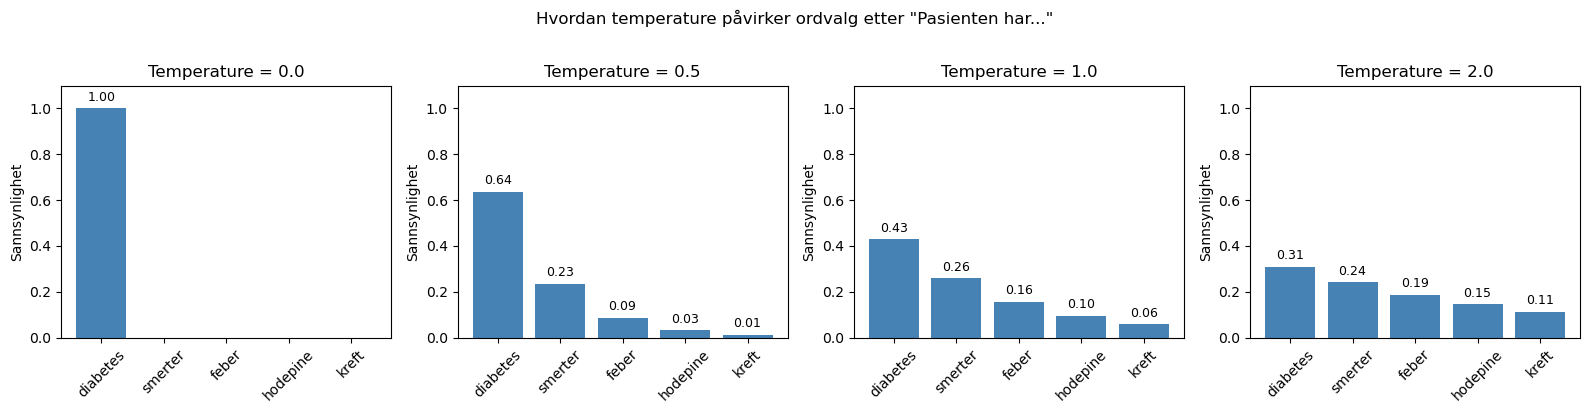

In [4]:
def apply_temperature(logits, temperature):
    """
    Anvend temperature på logits og beregn sannsynligheter.
    
    Args:
        logits: Rå modell-output (log-sannsynligheter)
        temperature: Skalering (0 = deterministisk, >1 = mer tilfeldig)
    
    Returns:
        Sannsynlighetsfordeling over tokens
    """
    if temperature == 0:
        # Deterministisk: sett all masse på høyeste
        probs = np.zeros_like(logits)
        probs[np.argmax(logits)] = 1.0
        return probs
    
    # Skaler logits med temperature
    scaled_logits = logits / temperature
    
    # Softmax for å få sannsynligheter
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))  # Numerisk stabilitet
    probs = exp_logits / np.sum(exp_logits)
    
    return probs

# Eksempel: Prediksjoner for neste ord etter "Pasienten har"
mulige_ord = ["diabetes", "smerter", "feber", "hodepine", "kreft"]
logits = np.array([2.5, 2.0, 1.5, 1.0, 0.5])  # Rå modell-output

# Visualiser effekten av temperature
temperatures = [0.0, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, temp in zip(axes, temperatures):
    probs = apply_temperature(logits, temp)
    bars = ax.bar(mulige_ord, probs, color='steelblue')
    ax.set_title(f'Temperature = {temp}')
    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Sannsynlighet')
    ax.tick_params(axis='x', rotation=45)
    
    # Legg til verdier
    for bar, prob in zip(bars, probs):
        if prob > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                   f'{prob:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Hvordan temperature påvirker ordvalg etter "Pasienten har..."', y=1.02)
plt.tight_layout()
plt.show()

In [5]:
def sample_next_word(probs, words):
    """Sample et ord basert på sannsynlighetsfordeling."""
    idx = np.random.choice(len(words), p=probs)
    return words[idx]

# Demonstrer sampling med ulike temperatures
print("Generering av 5 ord med ulike temperature-verdier:")
print("=" * 60)

np.random.seed(42)  # For reproduserbarhet

for temp in [0.0, 0.5, 1.0, 2.0]:
    probs = apply_temperature(logits, temp)
    samples = [sample_next_word(probs, mulige_ord) for _ in range(5)]
    print(f"\nTemperature {temp}:")
    print(f"  Genererte ord: {', '.join(samples)}")
    
    if temp == 0.0:
        print("  -> Alltid samme ord (deterministisk)")
    elif temp == 0.5:
        print("  -> Favoriserer høy-sannsynlighets ord")
    elif temp == 1.0:
        print("  -> Balansert variasjon")
    else:
        print("  -> Mer uforutsigbar, kan velge usannsynlige ord")

Generering av 5 ord med ulike temperature-verdier:

Temperature 0.0:
  Genererte ord: diabetes, diabetes, diabetes, diabetes, diabetes
  -> Alltid samme ord (deterministisk)

Temperature 0.5:
  Genererte ord: diabetes, diabetes, smerter, diabetes, smerter
  -> Favoriserer høy-sannsynlighets ord

Temperature 1.0:
  Genererte ord: diabetes, kreft, feber, diabetes, diabetes
  -> Balansert variasjon

Temperature 2.0:
  Genererte ord: diabetes, diabetes, smerter, smerter, diabetes
  -> Mer uforutsigbar, kan velge usannsynlige ord


### Praktisk anbefaling for medisinsk bruk

| Oppgave | Anbefalt temperature |
|---------|----------------------|
| Journalnotat | 0.0 - 0.3 |
| Sammendrag | 0.3 - 0.5 |
| Pasientinformasjon | 0.5 - 0.7 |
| Brainstorming | 0.8 - 1.2 |

---

## 4. Kontekstvindu

### Hva er kontekstvindu?

Kontekstvinduet er den maksimale mengden tekst en LLM kan "huske" og behandle samtidig. Alt utenfor dette vinduet er ukjent for modellen.

### Kontekstvinduer for populære modeller

| Modell | Kontekstvindu | Ca. sider tekst |
|--------|---------------|------------------|
| GPT-3.5 | 4,096 tokens | ~5 sider |
| GPT-4 | 8,192 tokens | ~10 sider |
| GPT-4 Turbo | 128,000 tokens | ~160 sider |
| Claude 3 | 200,000 tokens | ~250 sider |

In [6]:
# Typiske medisinske dokumenter og deres token-estimater
dokumenter = {
    "Kort konsultasjonsnotat": 200,
    "Standard journalnotat": 500,
    "Omfattende sykehistorie": 2000,
    "Full pasientjournal (1 år)": 10000,
    "Komplett pasientmappe (5 år)": 50000,
    "Medisinsk forskningsartikkel": 8000,
}

modeller = {
    "GPT-3.5": 4096,
    "GPT-4": 8192,
    "GPT-4 Turbo": 128000,
    "Claude 3": 200000,
}

print("Dokumentstørrelser vs. modellkapasitet:")
print("=" * 70)

for dok, tokens in dokumenter.items():
    print(f"\n{dok} (~{tokens:,} tokens):")
    for modell, kapasitet in modeller.items():
        if tokens <= kapasitet:
            utnyttelse = (tokens / kapasitet) * 100
            print(f"  {modell}: OK ({utnyttelse:.0f}% av kapasitet)")
        else:
            overskudd = tokens - kapasitet
            print(f"  {modell}: For stort ({overskudd:,} tokens over)")

Dokumentstørrelser vs. modellkapasitet:

Kort konsultasjonsnotat (~200 tokens):
  GPT-3.5: OK (5% av kapasitet)
  GPT-4: OK (2% av kapasitet)
  GPT-4 Turbo: OK (0% av kapasitet)
  Claude 3: OK (0% av kapasitet)

Standard journalnotat (~500 tokens):
  GPT-3.5: OK (12% av kapasitet)
  GPT-4: OK (6% av kapasitet)
  GPT-4 Turbo: OK (0% av kapasitet)
  Claude 3: OK (0% av kapasitet)

Omfattende sykehistorie (~2,000 tokens):
  GPT-3.5: OK (49% av kapasitet)
  GPT-4: OK (24% av kapasitet)
  GPT-4 Turbo: OK (2% av kapasitet)
  Claude 3: OK (1% av kapasitet)

Full pasientjournal (1 år) (~10,000 tokens):
  GPT-3.5: For stort (5,904 tokens over)
  GPT-4: For stort (1,808 tokens over)
  GPT-4 Turbo: OK (8% av kapasitet)
  Claude 3: OK (5% av kapasitet)

Komplett pasientmappe (5 år) (~50,000 tokens):
  GPT-3.5: For stort (45,904 tokens over)
  GPT-4: For stort (41,808 tokens over)
  GPT-4 Turbo: OK (39% av kapasitet)
  Claude 3: OK (25% av kapasitet)

Medisinsk forskningsartikkel (~8,000 tokens):
 

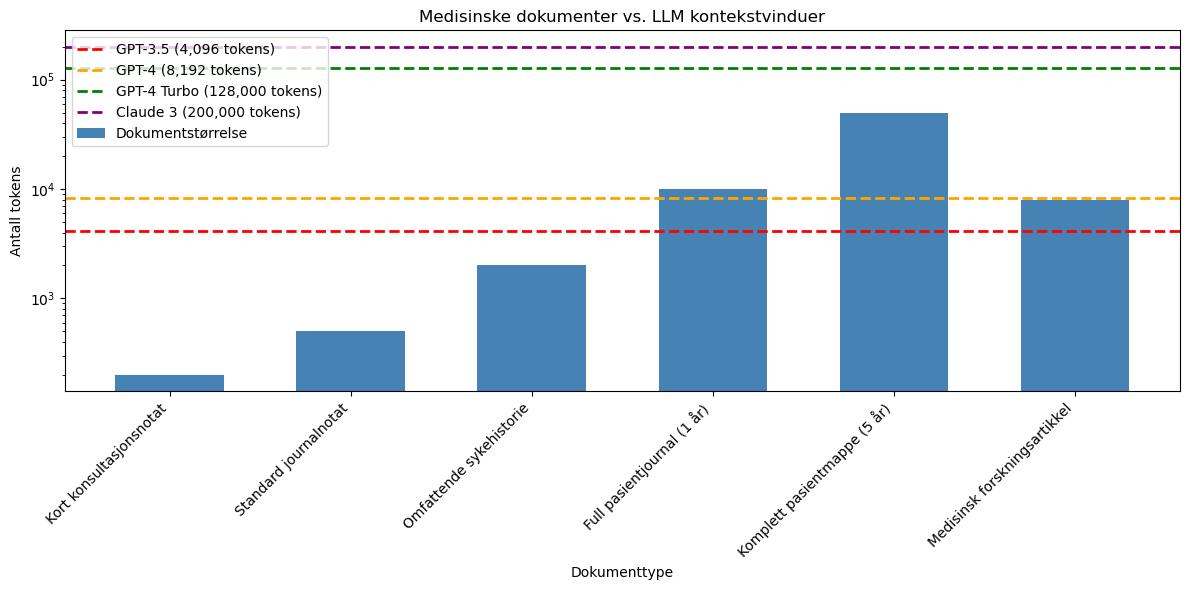

In [7]:
# Visualisering
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(dokumenter))
width = 0.6

bars = ax.bar(x, list(dokumenter.values()), width, color='steelblue', label='Dokumentstørrelse')

# Legg til horisontale linjer for modellkapasitet
colors = ['red', 'orange', 'green', 'purple']
for (modell, kapasitet), color in zip(modeller.items(), colors):
    ax.axhline(y=kapasitet, color=color, linestyle='--', linewidth=2, label=f'{modell} ({kapasitet:,} tokens)')

ax.set_xlabel('Dokumenttype')
ax.set_ylabel('Antall tokens')
ax.set_title('Medisinske dokumenter vs. LLM kontekstvinduer')
ax.set_xticks(x)
ax.set_xticklabels(list(dokumenter.keys()), rotation=45, ha='right')
ax.legend(loc='upper left')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

---

## 5. Praktiske implikasjoner

### Strategier for lange dokumenter

Når dokumenter overstiger kontekstvinduet, finnes flere strategier:

1. **Oppdeling (Chunking)**
   - Del dokumentet i mindre biter
   - Behandle hver del separat
   - Kombiner resultatene

2. **Sammendrag (Summarization)**
   - Lag et sammendrag av dokumentet først
   - Bruk sammendraget for videre analyse

3. **Retrieval-Augmented Generation (RAG)**
   - Indekser dokumentet i en database
   - Hent kun relevante deler basert på spørsmålet
   - Kombinér med LLM for svar

4. **Prioritering**
   - Identifiser mest relevant informasjon
   - Utelat mindre viktige deler

In [8]:
# Eksempel: Estimere tokens i et journalnotat

eksempel_journalnotat = """
Pasient: 65 år gammel mann
Henvisning: Utredning av brystsmerter

Anamnese:
Pasienten har hatt tilbakevendende brystsmerter de siste 3 månedene.
Smertene er lokalisert substernalt, stråler til venstre arm.
Utløses ved anstrengelse, bedres ved hvile.
Ingen kjente hjertesykdommer i familien.
Røyker 20 sigaretter daglig i 40 år.

Status:
Allmenntilstand god, ikke tungpust i hvile.
BT: 150/95, Puls: 75/min regulær
Hjertelytting: Normale toner, ingen bilyder
Lunger: Normale respirasjonslyd

Supplerende undersøkelser:
EKG: Normalt sinusrytme, ingen ST-forandringer
Troponin: <0.01 (normalt)
Kolesterol: 6.8 mmol/L (høyt)

Vurdering:
Sannsynlig stabil angina pectoris
Kardiovaskulære risikofaktorer: Røyking, hypertensjon, hyperkolesterolemi

Plan:
1. Stress-EKG for å bekrefte diagnose
2. Ekkokardiografi
3. Livsstilsråd: røykeslutt, kostomlegging
4. Medisinering: ASA 75mg, statin
5. Kontroll om 3 måneder
"""

if TIKTOKEN_AVAILABLE:
    tokens = encoding.encode(eksempel_journalnotat)
    print(f"Eksempel journalnotat:")
    print(f"  Antall tegn: {len(eksempel_journalnotat):,}")
    print(f"  Antall tokens: {len(tokens):,}")
    print(f"  Tegn per token: {len(eksempel_journalnotat)/len(tokens):.1f}")
    print(f"\nPasser i alle moderne LLM-er")
else:
    # Estimat: ~4 tegn per token for norsk tekst
    est_tokens = len(eksempel_journalnotat) // 4
    print(f"Estimert antall tokens: ~{est_tokens}")

Eksempel journalnotat:
  Antall tegn: 908
  Antall tokens: 341
  Tegn per token: 2.7

Passer i alle moderne LLM-er


---

## Oppsummering

### Hovedpunkter

1. **Tokens** er grunnenheten LLM-er bruker - vanligvis orddeler eller hele ord
2. **Medisinske termer** tokeniseres ofte til flere tokens (viktig for kostnad og ytelse)
3. **Temperature** kontrollerer kreativitet - bruk lav for medisinsk dokumentasjon
4. **Kontekstvindu** begrenser hvor mye tekst modellen kan behandle samtidig
5. **Strategier** som chunking og RAG kan håndtere lange dokumenter

### Refleksjonsoppgaver

1. Hvorfor tror du norske ord ofte tokeniseres til flere tokens enn engelske?
2. I hvilke kliniske situasjoner ville du brukt høy vs. lav temperature?
3. Hvordan ville du håndtere en pasient med 20 års journalhistorikk?

---

*Neste notebook: [04 - Prompt Engineering](04-prompt-engineering.ipynb)*